# Build Machine Learning Models for Divvy to Classify if a person is a Member or a Casual rider.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc, roc_curve,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pickle 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# load data

df= pd.read_csv('divvy.csv')

#### split datasets

In [3]:

train, test = train_test_split(df, test_size=0.2, random_state= 42)

In [4]:
#A1 reset index for the train dataset

train.reset_index(drop=True, inplace=True)


In [5]:
#A2 check for empty strings in all column for train set

(train[train == ' ']).count()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [129]:
#A2 replace missing start_station_name and start_station_id columns with mode output

#train[['start_station_name','start_station_id','end_station_name','end_station_id']].mode()
#train['start_station_name'].fillna('Kingsbury St & Kinzie St', inplace= True)
#train['start_station_id'].fillna('KA1503000043', inplace= True)
#train['end_station_name'].fillna('Clinton St & Washington Blvd', inplace= True)
#train['end_station_id'].fillna('WL-012', inplace= True)

In [130]:
#A3 drop missing values for end_lat and end_lng

#train= train.dropna()

#### Check and verify column types

In [6]:
train.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

### Data cleaning and feature engineering

In [ ]:
#A4 change date format

train['started_at'] = pd.to_datetime(train['started_at'])
train['ended_at'] = pd.to_datetime(train['ended_at'])

In [23]:
#5 featuring a ride_start_hour column

train["ride_start_hour"] = train["started_at"].dt.hour.astype('int64')

In [24]:
train.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
ride_start_hour                int64
dtype: object

In [25]:
train.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_start_hour'],
      dtype='object')

In [26]:
train.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
ride_start_hour                int64
dtype: object

In [27]:
#6 featuring a ride day column

train["ride_day"] = pd.to_datetime(train["started_at"]).dt.strftime('%A')

In [28]:
#A7 new column for ride duration in minutes

train['ride_duration(mins)'] = (train['ended_at'] - train['started_at']).dt.total_seconds()/60
train['ride_duration(mins)'] = train['ride_duration(mins)'].round(0)

In [29]:
#A9 ride_time_category column

train['ride_time_category'] = 'Off-Peak'
train.loc[(train['ride_start_hour'] >= 7) & (train['ride_start_hour'] <= 10), 'ride_time_category'] = 'Peak'

In [30]:
#10 drop outlier for the ride_duration column

def drop_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [31]:
train = drop_outlier(train, 'ride_duration(mins)')

In [32]:
from math import sin, cos, sqrt, atan2, radians



# Approximate radius of earth in km
R = 6373.0

lat1 = radians(train['start_lat'].astype('float'))
lon1 = radians(train['start_lng'].astype('float'))
lat2 = radians(train['end_lat'].astype('float'))
lon2 = radians(train['end_lng'].astype('float'))
dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

D = R * c




In [38]:
train.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_start_hour', 'ride_day', 'ride_duration(mins)',
       'ride_time_category'],
      dtype='object')

In [39]:
# A11 drop columns

train.drop(['ride_id',  'start_station_id', 'end_station_id','started_at', 'ended_at',  'start_station_name',
             'end_station_name', 'start_lat','end_lat'], axis= 1, inplace= True)


C:\Users\USER\AppData\Local\Temp\ipykernel_5540\2851813021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['ride_id',  'start_station_id', 'end_station_id','started_at', 'ended_at',  'start_station_name',


In [40]:
# new available columns

train.columns

Index(['rideable_type', 'start_lng', 'end_lng', 'member_casual',
       'ride_start_hour', 'ride_day', 'ride_duration(mins)',
       'ride_time_category'],
      dtype='object')

In [41]:
train.dtypes

rideable_type           object
start_lng              float64
end_lng                float64
member_casual           object
ride_start_hour          int64
ride_day                object
ride_duration(mins)    float64
ride_time_category      object
dtype: object

In [42]:
# splitting our train dataset into features and targets

target = 'member_casual'
x_train = train.drop(target, axis =1) # features
y_train = train[target] #target

In [44]:
# write functions to show the categorical and numerical column for the x_train

cat= []
for i in x_train.columns:
    if x_train[i].dtype == 'object':
        cat.append(i)

num = []
for i in x_train.columns:
    if x_train[i].dtype == 'int64' or train[i].dtype == 'float64':
        num.append(i)

In [45]:
num

['start_lng', 'end_lng', 'ride_start_hour', 'ride_duration(mins)']

In [46]:
cat

['rideable_type', 'ride_day', 'ride_time_category']

In [47]:
# transforming the categorical and the numerical column

cat_trans = Pipeline([
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first', sparse= False))
])

num_trans = Pipeline([
    ("Imputer", SimpleImputer(strategy='mean')),
    ("scalar", MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_trans, num),
        ('cat', cat_trans, cat)
    ]
)

pipeline= Pipeline([
    ('preprocessor', preprocessor)
])

In [48]:
# applying the transformations

pipe_fit = pipeline.fit(x_train)

c:\Users\USER\Desktop\python_class\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
x_train1= pd.DataFrame(pipe_fit.transform(x_train), columns= pipe_fit.get_feature_names_out().tolist())

In [51]:
x_train1.columns

Index(['num__start_lng', 'num__end_lng', 'num__ride_start_hour',
       'num__ride_duration(mins)', 'cat__rideable_type_docked_bike',
       'cat__rideable_type_electric_bike', 'cat__ride_day_Monday',
       'cat__ride_day_Saturday', 'cat__ride_day_Sunday',
       'cat__ride_day_Thursday', 'cat__ride_day_Tuesday',
       'cat__ride_day_Wednesday', 'cat__ride_time_category_Peak'],
      dtype='object')

<Axes: >

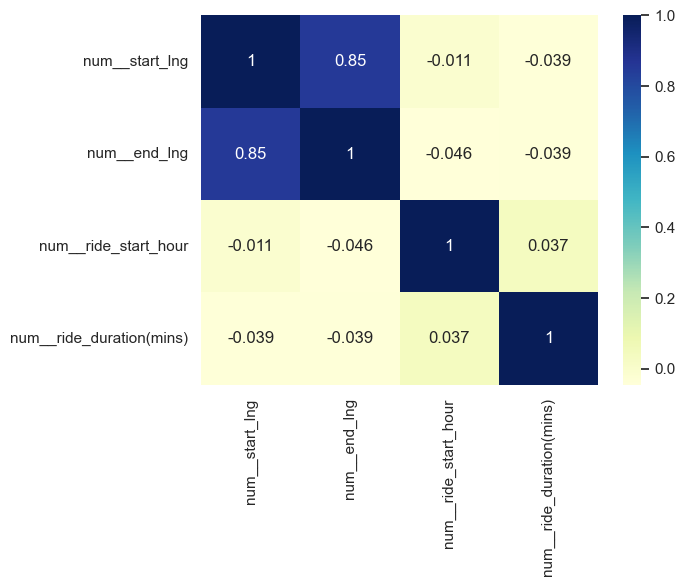

In [52]:
cors= x_train1[['num__start_lng', 'num__end_lng', 'num__ride_start_hour',
       'num__ride_duration(mins)']].corr()
sns.heatmap(cors, annot=True,cmap="YlGnBu")

In [53]:
dt= DecisionTreeClassifier()
dt.fit(x_train1, y_train)
predictors = x_train1.columns

coef = pd.Series(dt.feature_importances_, predictors).sort_values(ascending= False)
coef.to_frame()

,0
num__start_lng,0.311375
num__end_lng,0.262330
num__ride_start_hour,0.140927
num__ride_duration(mins),0.135552
cat__ride_day_Thursday,0.023110
cat__rideable_type_docked_bike,0.022248
cat__ride_day_Monday,0.019979
cat__ride_day_Tuesday,0.019296
cat__ride_day_Wednesday,0.018711
cat__rideable_type_electric_bike,0.018155


In [59]:
## transform y_train

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [60]:
y_train

array([1, 0, 1, ..., 0, 1, 0])

In [61]:
def prepare(d) :
    d.reset_index(drop=True, inplace=True)


    d['started_at'] = pd.to_datetime(d['started_at'])
    d['ended_at'] = pd.to_datetime(d['ended_at'])



    d["ride_day"] = pd.to_datetime(d["started_at"]).dt.strftime('%A')

    d['ride_duration(mins)'] = (d['ended_at'] - d['started_at']).dt.total_seconds()/60
    d['ride_duration(mins)'] = d['ride_duration(mins)'].round(0)

    d["ride_start_hour"] = d["started_at"].dt.hour.astype('int64')
   
    d['ride_time_category'] = 'Off-Peak'
    d.loc[(train['ride_start_hour'] >= 7) & (d['ride_start_hour'] <= 10), 'ride_time_category'] = 'Peak'


    d = drop_outlier(d, 'ride_duration(mins)')

    d.drop(['ride_id',  'start_station_id', 'end_station_id','started_at', 'ended_at',  'start_station_name',
             'end_station_name', 'start_lat','end_lat'], axis= 1, inplace= True)
    
    target = 'member_casual'
    x_test = d.drop(target, axis =1) # features
    y_test = d[target] #target

    x_test= pd.DataFrame(pipe_fit.transform(x_test), columns= pipe_fit.get_feature_names_out().tolist())

    y_test= le.transform(y_test)

    return x_test, y_test

In [62]:
x_test, y_test = prepare(test)

C:\Users\USER\AppData\Local\Temp\ipykernel_5540\3862928021.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.drop(['ride_id',  'start_station_id', 'end_station_id','started_at', 'ended_at',  'start_station_name',


#### balance for the over and under sampling

In [63]:


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [64]:
ros = RandomOverSampler()

x_train_bal, y_train_bal = ros.fit_resample(x_train1, y_train)

In [66]:
# writing for evaluation function for different models

def model_to_use(input_ml_algo):
    if input_ml_algo == 'DT':
        model = DecisionTreeClassifier()
    elif input_ml_algo == 'RF':
        model = RandomForestClassifier()
    elif input_ml_algo == 'XGBC':
        model = XGBClassifier()
    elif input_ml_algo=='LR':
        model=LogisticRegression()
    elif input_ml_algo=='KNN':
        model=KNeighborsClassifier()
    return model


#Write a function evaluate the performance of the model, 
# print the AUC curve as well as the confusion matrix table
def performance(model,X_train,y_train,X_test, y_test):
    y_pred = model.predict(X_test)

    # Predict probability for test dataset
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = [x[1] for x in y_pred_prob]

    col = le.inverse_transform([0,1])

    disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    cmap='Blues', values_format='d',display_labels=col

 )

    print("\n Accuracy Score : \n ",accuracy_score(y_test,y_pred))
    print("\n AUC Score : \n", roc_auc_score(y_test, y_pred_prob))
    print("\n Confusion Matrix : \n ",confusion_matrix(y_test, y_pred))
    print("\n Classification Report : \n",classification_report(y_test, y_pred, target_names=col))

    print("\n ROC curve : \n")
    sns.set_style("white")
    RocCurveDisplay.from_estimator(model,X_test, y_test,)
    plt.show()


 Accuracy Score : 
  0.6947816071586781

 AUC Score : 
 0.58861493321709

 Confusion Matrix : 
  [[ 3136  5096]
 [ 5239 20390]]

 Classification Report : 
               precision    recall  f1-score   support

      casual       0.37      0.38      0.38      8232
      member       0.80      0.80      0.80     25629

    accuracy                           0.69     33861
   macro avg       0.59      0.59      0.59     33861
weighted avg       0.70      0.69      0.70     33861


 ROC curve : 



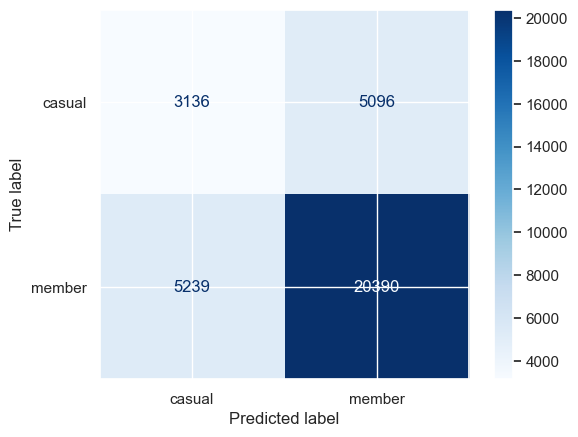

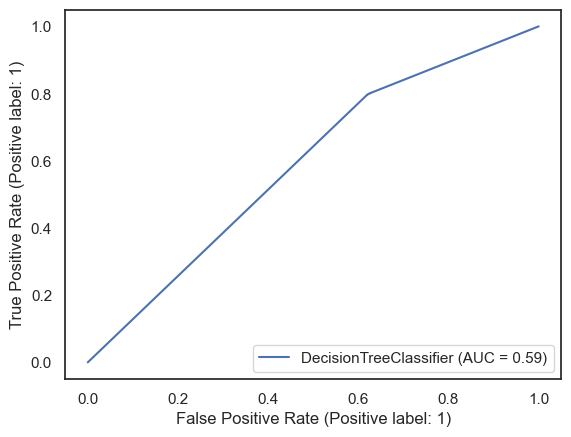

In [67]:
## decision tree

model1 = model_to_use("DT")
model1.fit(x_train_bal, y_train_bal)
performance(model1, x_train_bal, y_train_bal, x_test, y_test )


 Accuracy Score : 
  0.731313310297983

 AUC Score : 
 0.6627572790457967

 Confusion Matrix : 
  [[ 2597  5635]
 [ 3463 22166]]

 Classification Report : 
               precision    recall  f1-score   support

      casual       0.43      0.32      0.36      8232
      member       0.80      0.86      0.83     25629

    accuracy                           0.73     33861
   macro avg       0.61      0.59      0.60     33861
weighted avg       0.71      0.73      0.72     33861


 ROC curve : 



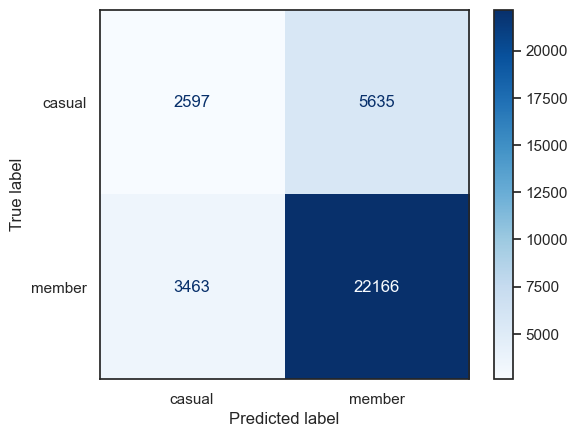

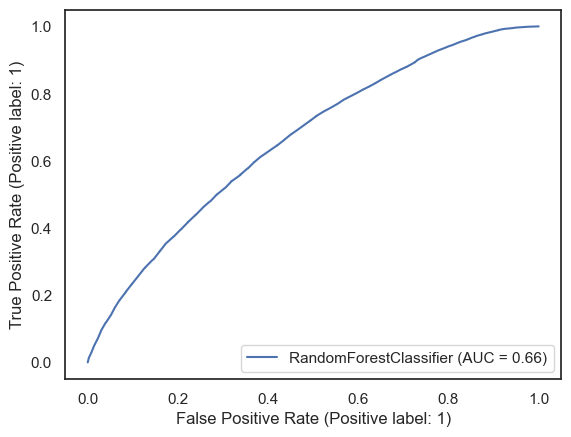

In [68]:
# random forest

model2 = model_to_use("RF")
model2.fit(x_train_bal, y_train_bal)
performance(model2, x_train_bal, y_train_bal, x_test, y_test )


 Accuracy Score : 
  0.5867812527686719

 AUC Score : 
 0.6318292309705497

 Confusion Matrix : 
  [[ 4901  3331]
 [10661 14968]]

 Classification Report : 
               precision    recall  f1-score   support

      casual       0.31      0.60      0.41      8232
      member       0.82      0.58      0.68     25629

    accuracy                           0.59     33861
   macro avg       0.57      0.59      0.55     33861
weighted avg       0.70      0.59      0.62     33861


 ROC curve : 



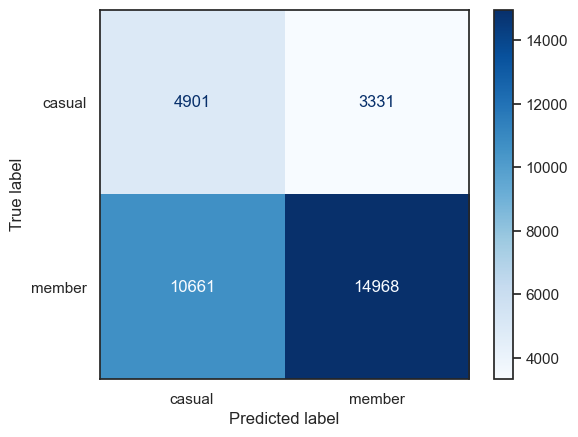

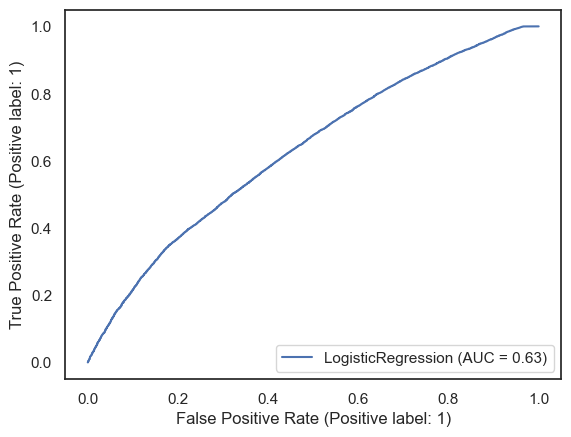

In [69]:
# Linear  regression model

model3 = model_to_use("LR")
model3.fit(x_train_bal, y_train_bal)
performance(model3, x_train_bal, y_train_bal, x_test, y_test )


 Accuracy Score : 
  0.6438675762676825

 AUC Score : 
 0.6903971608821564

 Confusion Matrix : 
  [[ 4974  3258]
 [ 8801 16828]]

 Classification Report : 
               precision    recall  f1-score   support

      casual       0.36      0.60      0.45      8232
      member       0.84      0.66      0.74     25629

    accuracy                           0.64     33861
   macro avg       0.60      0.63      0.59     33861
weighted avg       0.72      0.64      0.67     33861


 ROC curve : 



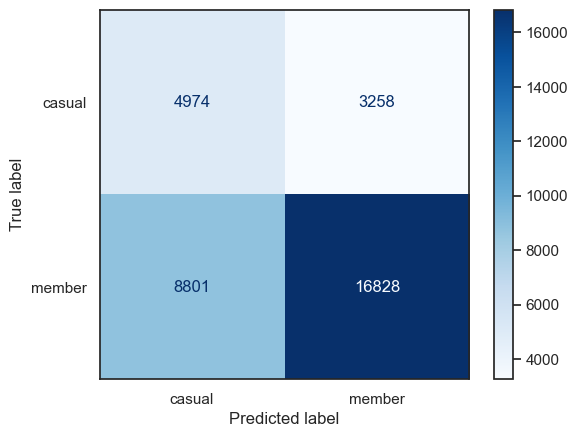

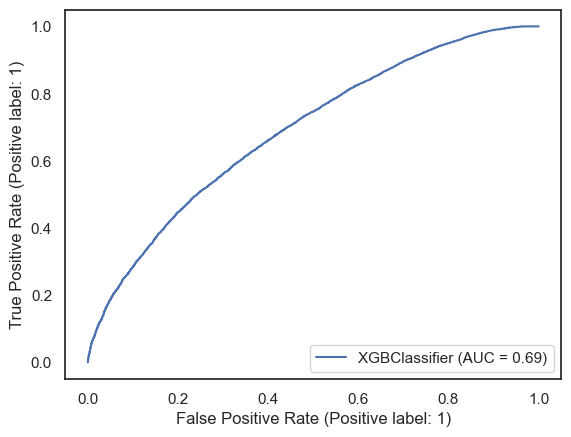

In [70]:
# XGBC model

model4 = model_to_use("XGBC")
model4.fit(x_train_bal, y_train_bal)
performance(model4, x_train_bal, y_train_bal, x_test, y_test )


 Accuracy Score : 
  0.588553202799681

 AUC Score : 
 0.5899925180799008

 Confusion Matrix : 
  [[ 4257  3975]
 [ 9957 15672]]

 Classification Report : 
               precision    recall  f1-score   support

      casual       0.30      0.52      0.38      8232
      member       0.80      0.61      0.69     25629

    accuracy                           0.59     33861
   macro avg       0.55      0.56      0.54     33861
weighted avg       0.68      0.59      0.62     33861


 ROC curve : 



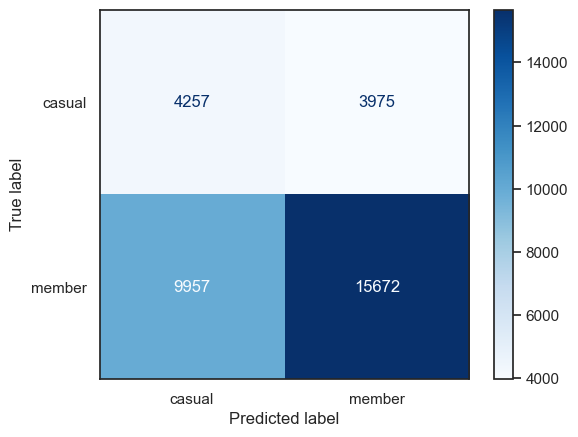

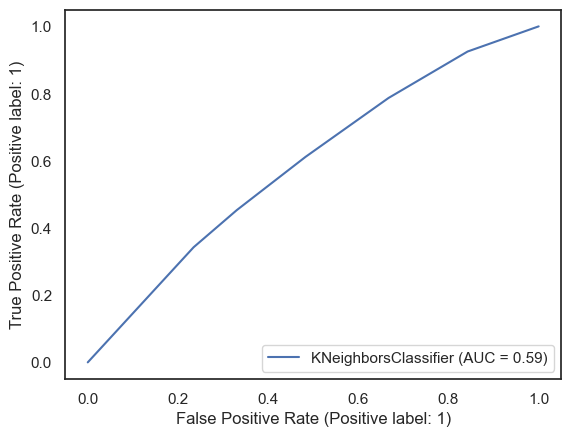

In [72]:
# KNM model

model5 = model_to_use("KNN")
model5.fit(x_train_bal, y_train_bal)
performance(model5, x_train_bal, y_train_bal, x_test, y_test )